## Bayesian Optimisation Verification

In [54]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
from scipy.stats import norm
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from scipy.optimize import fsolve
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [76]:
# #import timestamp from data sheet (time:0~5000s) 
address = 'data/degradation.xlsx'
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [0],names = None,nrows = 5000)
df_time = df.values.tolist()

In [56]:
#import data sheet at 85 C (time:0~5000s) 

df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85 = df.values.tolist() 
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_85s = df.values.tolist()

In [57]:
# Format date into numpy array format
# x_normal = np.array(df_time).T
y_normal = np.array(df_85).T 
# x_normal = x_normal.reshape((5000))
y_normal = y_normal.reshape((5000))
X_ = np.linspace(0,5000, 5000)
x_normal = X_
x_7_5000 = np.array([0,99,999,1999,2999,3999,4999])

In [58]:
# Plot function
def plot (x_normal ,y_normal, X,X_,y_mean,Y,y_cov):
    #plot function
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=1, zorder=4)
    plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
    # plt.scatter(X[:, 0], Y, c='r', s=1, zorder=3)
    plt.plot(x_normal, y_normal, 'c', lw=1, zorder=2)
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title('Original')
    plt.xlim(0,4900)
    plt.ylim(0.7,0.8)
    plt.tight_layout()
    plt.show()

In [61]:
def ucb(X , gp, dim, delta):
	"""
	Calculates the GP-UCB acquisition function values
	Inputs: gp: The Gaussian process, also contains all data
	x:The point at which to evaluate the acquisition function 
	Output: acq_value: The value of the aquisition function at point x
	"""
	mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
	mean = np.atleast_2d(mean).T
	var = np.atleast_2d(var).T  
	beta = 2*np.log(np.power(5000,2.1)*np.square(np.pi)/(3*delta))
	return mean - np.sqrt(beta) * np.sqrt(np.diag(var))

def ei(X, gp, y_max):
	"""
	Calculates the EI acquisition function values
	Inputs: gp: The Gaussian process, also contains all data
			y_max: The maxima of the found y values
			x:The point at which to evaluate the acquisition function 
	Output: acq_value: The value of the aquisition function at point x
	"""
	y_max = np.asscalar(y_max)
	mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
	var2 = np.maximum(var, 1e-8 + 0 * var)
	z = (mean - y_max)/np.sqrt(var2)        
	out=(mean - y_max) * norm.cdf(z) + np.sqrt(var2) * norm.pdf(z)
	out[var2<1e-8]=0
	return out

def rucb_balance(X, gp, dim, delta):
	"""
	Calculates the RGP-UCB acquisition function values with a theta
	favoring a balance of exploration and expoitation.
	Inputs: gp: The Gaussian process, also contains all data
			x:The point at which to evaluate the acquisition function 
	Output: acq_value: The value of the aquisition function at point x
	"""

	mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
	mean = np.atleast_2d(mean).T
	var = np.atleast_2d(var).T
	#np.random.seed(5000*iterations_num)
	theta=1
	k=np.log((np.square(5000)+1)/np.sqrt(2)*math.pi)/np.log(1+theta/2)
	distbeta=np.random.gamma(scale=k,shape=theta,size=1)         
	#print('k={}, theta={}'.format(k,theta))
	return mean - np.sqrt(distbeta)* np.sqrt(np.diag(var))

In [70]:
def newplot(X,Y,X_, y_mean,ucb_y_min):
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean, ucb_y_min,alpha=0.5, color='k')
    plt.scatter(X[:, 0], Y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.scatter(np.argmin(ucb_y_min),min(ucb_y_min),c='g', s=50)
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.tight_layout()
    plt.show()

In [108]:
def find_lsb_max (x_normal ,y_normal,X,X_,Y):
    # Kernel setting
    # Length scale list from 10^-5 to 10^5 in 0.1 increments 
    ls_power = np.linspace(0,4,41)
    ls_list = np.power(10,ls_power)
    length_scale_bounds_MIN = 1e-6

    for length_scale_bounds_MAX in ls_list:
        kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
        gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
        y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
        # print ('Average absolute error:',
        # np.format_float_scientific(np.mean(np.absolute(y_normal-y_mean)),precision=5))
        average_percentage_error = np.mean(np.absolute((y_normal-y_mean)/y_normal*100))
        # print('Length scale bound max =',length_scale_bounds_MAX,' Percentage error =',average_percentage_error)

        if average_percentage_error < 0.11:
            break
    print('Length scale bound max =',length_scale_bounds_MAX)
    print ('Average percentage error:',
    np.format_float_positional(np.mean(np.absolute((y_normal-y_mean)/y_normal*100)),precision=4),'%')
    plot(x_normal ,y_normal, X,X_,y_mean,Y,y_cov)
    return int(length_scale_bounds_MAX)

# find_lsb_max (x_normal ,y_normal,X,X_,Y)


Length scale bound max = 630.9573444801937
Average percentage error: 0.1043 %


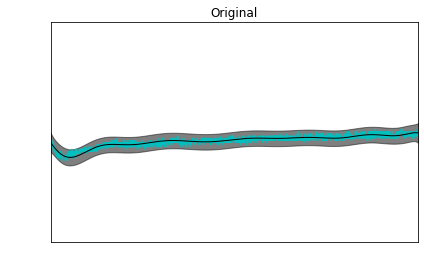

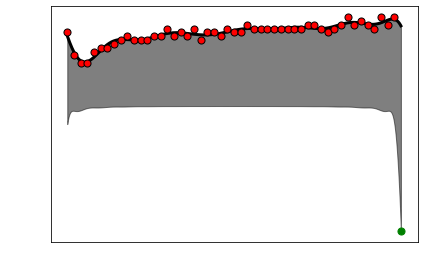

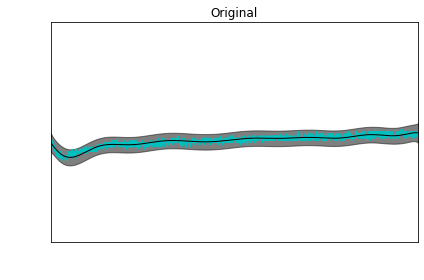

In [110]:
NUM_OF_DATA_POINTS = 50
x_loop = np.arange(0,5000,int(5000/NUM_OF_DATA_POINTS))
X = x_normal[x_loop].reshape(x_loop.size)
Y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)
X_ = np.linspace(0,5000, 5000)
# Kernel setting
length_scale_bounds_MAX = find_lsb_max (x_normal ,y_normal,X,X_,Y)
length_scale_bounds_MIN = 10e-6
kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)

# Find the prediction by 
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
acp_value = ucb(X_, gp, 0.1, 5)
ucb_y_min = acp_value[-1]
newplot(X,Y,X_, y_mean,ucb_y_min)
plot(x_normal ,y_normal, X,X_,y_mean,Y,y_cov)


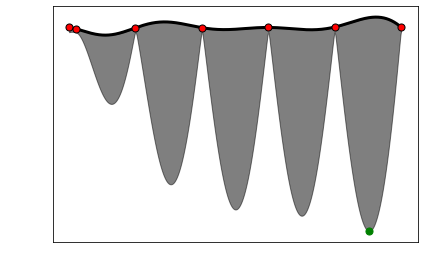

New x value: 4517 y value: 0.74822 
All x values: [   0   99  999 1999 2999 3999 4517 4999]
Length scale bound max = 100000.0
Average percentage error: 92.9669 %


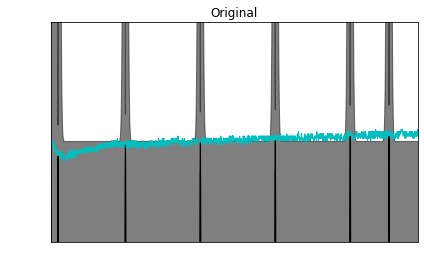

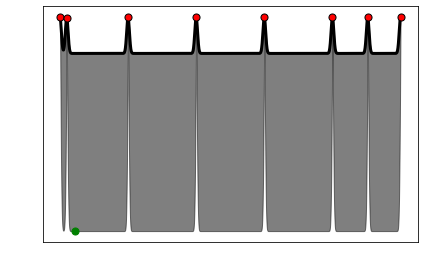

New x value: 219 y value: 0.73822 
All x values: [   0   99  219  999 1999 2999 3999 4517 4999]


KeyboardInterrupt: 

In [78]:
# Iterate i times with mins value point of each ucb bound
# Initiate with 7 data points, apply log transformation to them
x_loop = x_7_5000 
X = x_normal[x_loop].reshape(x_loop.size)
Y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)
X_ = np.linspace(0,5000, 5000)
# Kernel setting
length_scale_bounds_MAX = 700
length_scale_bounds_MIN = 0.01
kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)

# Find the prediction by 
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
acp_value = ucb(X_, gp, 0.1, 5)
ucb_y_min = acp_value[-1]
newplot(X,Y,X_, y_mean,ucb_y_min)

# Change i to set extra data points
i=0

while i < 2:
    # Find minimum y value in ucb
    index = np.argmin(acp_value[-1])

    # Protection to stop equal x value
    while index in x_loop:
        index = index -  50
    x_loop = np.append(x_loop, index)
    x_loop = np.sort(x_loop)
    # Update X and Y with extra data point
    print ('New x value:',index,'y value:',y_normal[index], '\nAll x values:',x_loop)
    X = x_normal[x_loop].reshape(x_loop.size)
    Y = y_normal[x_loop]
    X = X.reshape(x_loop.size,1)
    # Update kernel in every interration
    length_scale_bounds_MAX = find_lsb_max (x_normal ,y_normal,X,X_,Y)
    length_scale_bounds_MIN = 1e-6
    kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
    # Update gp and plot relevant infomation and plot the new graph
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
    acp_value = ucb(X_, gp, 0.1, 5)
    ucb_y_min = acp_value[-1]
    newplot(X,Y,X_, y_mean,ucb_y_min)

    i+=1
# Result after a few interations
print('X:', X, '\nY:', Y)
s = interpolate.InterpolatedUnivariateSpline(x_loop,Y)
x_uni = np.arange(0,5000,1)
y_uni = s(x_uni)

# Plot figure
plt.plot(df_time,df_85s,'-',color = 'gray')
plt.plot(x_uni,y_uni,'-',color = 'red')
plt.plot(x_loop,  Y,'x',color = 'black')
plt.tick_params(axis='y', colors = 'white')
plt.tick_params(axis='x', colors = 'white')
plt.ylabel('Lifetime',color = 'white')
plt.xlabel('Time',color = 'white')
plt.title('cycle %d'%(i+1), color = 'white')


plt.show()

[[2.94324598e-04 3.66524379e-05 2.65670463e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.58415201e-05 1.21944843e-02 1.69653577e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.51717894e-05 1.82062733e-02 2.55803728e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.13231263e-02
  6.12095223e-02 6.08743875e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.12095223e-02
  6.13231263e-02 6.12095223e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.08743875e-02
  6.12095223e-02 6.13231263e-02]]
Number of data points used: 20
Length scale bound max = 400
Average absolute error: 6.00136e-01
Average percentage error: 80.4438 %


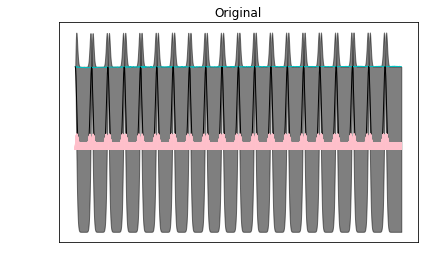

[[2.94324992e-04 3.66525280e-05 2.65671285e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.58416910e-05 1.21962305e-02 1.69678338e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.51719594e-05 1.82087677e-02 2.55838959e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.17952807e-01
  1.14268195e-01 1.10252467e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.21616704e-01
  1.18110440e-01 1.14250541e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.24812354e-01
  1.21482110e-01 1.17797980e-01]]
Number of data points used: 31
Length scale bound max = 400
Average absolute error: 5.19087e-01
Average percentage error: 69.5819 %


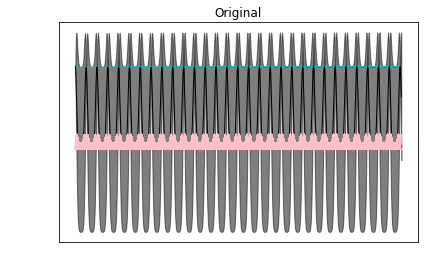

[[2.94324686e-04 3.66525509e-05 2.65673692e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.58415604e-05 1.21949788e-02 1.69660617e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.51718310e-05 1.82069792e-02 2.55813728e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.13293950e-02
  6.12157831e-02 6.08806252e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.12157833e-02
  6.13293947e-02 6.12157829e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.08806256e-02
  6.12157831e-02 6.13293945e-02]]
Number of data points used: 40
Length scale bound max = 400
Average absolute error: 4.50569e-01
Average percentage error: 60.3943 %


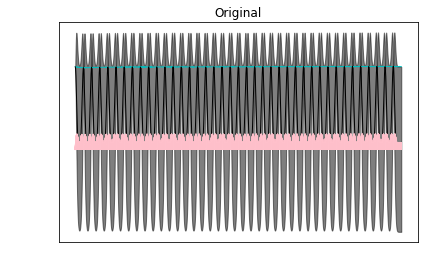

[[2.42459949e-04 4.85973411e-05 4.51078465e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.04619378e-05 2.31965782e-04 4.35863173e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.86968129e-05 4.53148110e-05 2.21939219e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.59162649e-03
  2.47294363e-03 2.47066689e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.50730087e-03
  2.62052892e-03 2.50334022e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.53972454e-03
  2.53804464e-03 2.64964482e-03]]
Number of data points used: 50
Length scale bound max = 400
Average absolute error: 8.27238e-04
Average percentage error: 0.1109 %


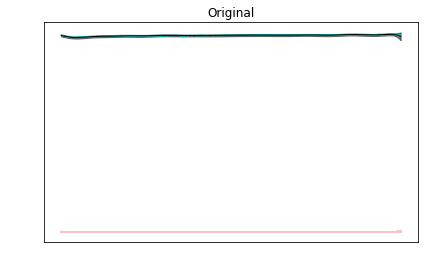

[[2.17485774e-04 3.84630097e-05 3.52483652e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.02499239e-05 2.06744679e-04 3.38773225e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.86492561e-05 3.54961538e-05 1.96542144e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.26012563e-04
  3.30340283e-04 3.30879204e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.37853700e-04
  6.31445668e-04 3.39310440e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.46082223e-04
  3.47004648e-04 6.37147388e-04]]
Number of data points used: 61
Length scale bound max = 400
Average absolute error: 7.7597e-04
Average percentage error: 0.1040 %


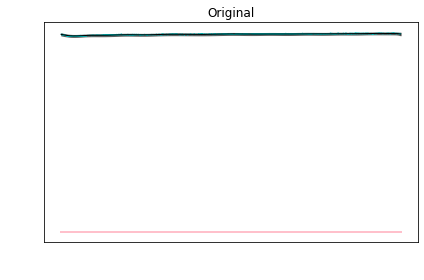

[[2.12636437e-04 3.37441465e-05 3.07069696e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.53874302e-05 2.01764668e-04 2.93609003e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.38198828e-05 3.08352568e-05 1.91433322e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.97509518e-04
  3.92288450e-04 3.89879360e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.05080830e-04
  6.02664630e-04 4.00455069e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.15654496e-04
  4.13443086e-04 6.08015426e-04]]
Number of data points used: 81
Length scale bound max = 400
Average absolute error: 7.91075e-04
Average percentage error: 0.1060 %


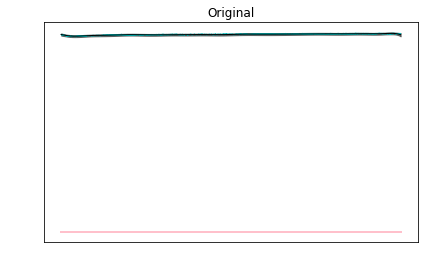

[[1.57925410e-04 1.74237572e-05 1.54945542e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.84930592e-05 1.48547158e-04 1.46553742e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.74892779e-05 1.55853410e-05 1.39693087e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.27464127e-03
  1.03025255e-03 1.03295134e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.04452234e-03
  1.29135607e-03 1.05042354e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.06174301e-03
  1.06494834e-03 1.30833170e-03]]
Number of data points used: 100
Length scale bound max = 400
Average absolute error: 7.58566e-04
Average percentage error: 0.1017 %


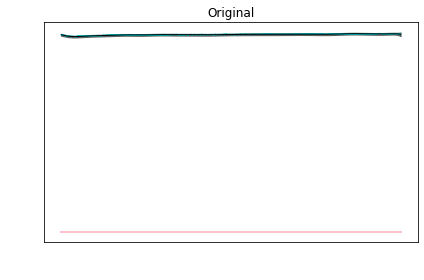

[[1.86877555e-04 2.11726053e-05 1.87620183e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.25719379e-05 1.75868495e-04 1.77583706e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.13701707e-05 1.89727967e-05 1.65459012e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.43357746e-04
  4.17233230e-04 4.18913155e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.26006295e-04
  6.53297790e-04 4.29685609e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.36661828e-04
  4.38664615e-04 6.63476826e-04]]
Number of data points used: 122
Length scale bound max = 400
Average absolute error: 7.38221e-04
Average percentage error: 0.0989 %


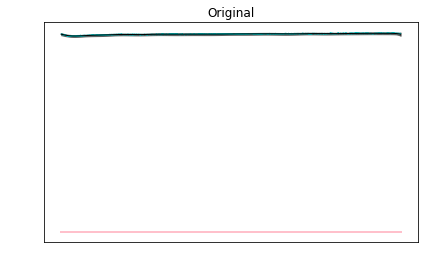

[[2.35662505e-04 2.84822181e-05 2.50965559e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.06168838e-05 2.21758383e-04 2.38139492e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.90741617e-05 2.56645109e-05 2.08586786e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.68429148e-04
  1.23405017e-04 1.23518675e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.27840636e-04
  3.70731482e-04 1.28227484e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.32524499e-04
  1.32801335e-04 3.73203023e-04]]
Number of data points used: 152
Length scale bound max = 400
Average absolute error: 7.25682e-04
Average percentage error: 0.0973 %


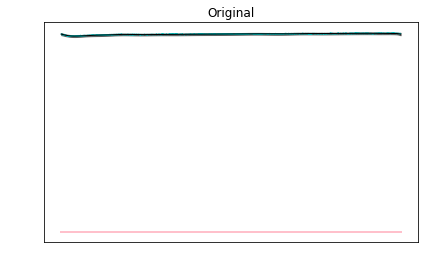

[[1.39248841e-04 7.16964475e-06 6.10094584e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.80456531e-06 1.30231267e-04 5.66294902e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.25224038e-06 6.18389398e-06 1.21753359e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.18584785e-04
  2.32498349e-04 2.32654806e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.39290041e-04
  5.22415991e-04 2.39821051e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.46407909e-04
  2.46786217e-04 5.26428518e-04]]
Number of data points used: 200
Length scale bound max = 400
Average absolute error: 7.19364e-04
Average percentage error: 0.0964 %


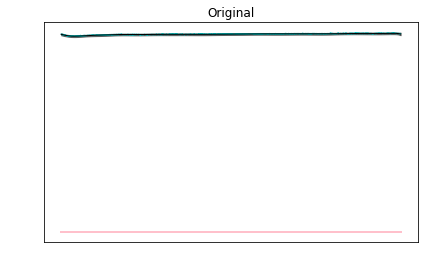

[[1.31027324e-04 3.03126983e-06 2.46055940e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.40048619e-06 1.22128062e-04 2.24553087e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.11045909e-06 2.53040061e-06 1.13792918e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.68624509e-04
  2.98933318e-05 2.96644938e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.17948292e-05
  2.66890501e-04 3.13762586e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.35420984e-05
  3.33548210e-05 2.65277570e-04]]
Number of data points used: 313
Length scale bound max = 400
Average absolute error: 7.08901e-04
Average percentage error: 0.0950 %


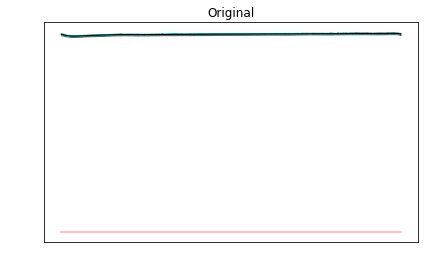

[[1.07533312e-004 5.39637915e-007 4.09379722e-007 ... 5.12959784e-281
  4.48266170e-287 2.68522952e-293]
 [6.26102657e-007 1.00331971e-004 3.61296688e-007 ... 5.12959784e-281
  4.48266170e-287 2.68522952e-293]
 [5.54585330e-007 4.21852321e-007 9.35891766e-005 ... 5.12959784e-281
  4.48266170e-287 2.68522952e-293]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 3.58622606e-004
  4.00609204e-005 4.02948892e-005]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 4.18848425e-005
  3.57967834e-004 4.24411472e-005]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 4.40298226e-005
  4.43546445e-005 3.57430543e-004]]
Number of data points used: 500
Length scale bound max = 400
Average absolute error: 6.97663e-04
Average percentage error: 0.0935 %


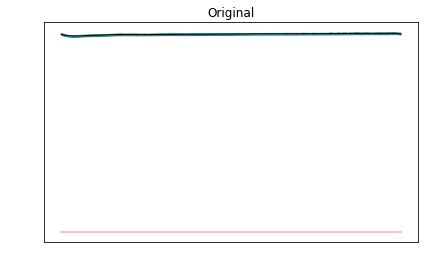

In [62]:
# Preparing training set from a range of data points
# Kernel setting
length_scale_bounds_MAX = 400
length_scale_bounds_MIN = 1e-4

for NUM_OF_DATA_POINTS in (20,30,40,50,60,80,100,120,150,200,300,500):
    x_loop = np.arange(0,5000,int(5000/NUM_OF_DATA_POINTS))
    X = x_normal[x_loop].reshape(x_loop.size)
    Y = y_normal[x_loop]
    X = X.reshape(x_loop.size,1)
    
    kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.00000001)
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

    # Get ucb prediction
    acp_value = ucb(X_, gp, 0.1, 5)
    # X_min = np.argmin(acp_value[-1])
    # ucb_y_min = acp_value[-1]
    ei_value = ei(X_, gp, max(y_normal))
    print(ei_value)
    rucb_value = rucb_balance(X_, gp, 0.1,5)

    print('Number of data points used:', x_loop.size)
    print('Length scale bound max =',length_scale_bounds_MAX)
    print ('Average absolute error:',
    np.format_float_scientific(np.mean(np.absolute(y_normal-y_mean)),precision=5))
    print ('Average percentage error:',
    np.format_float_positional(np.mean(np.absolute((y_normal-y_mean)/y_normal*100)),precision=4),'%')
    
    #plot function
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=1, zorder=4)
    plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
    plt.plot(x_normal, y_normal, 'c', lw=1, zorder=2)
    # plt.plot(x_normal,ucb_y_min,'pink',lw=1,zorder=5)
    # plt.scatter(np.argmin(ucb_y_min), min(ucb_y_min), c='r', s=20, zorder=6)
    # plt.plot(x_normal,acp_value,'pink',lw=1,zorder=5)
    # plt.plot(x_normal,acp_value[0],'pink',lw=1,zorder=5)
    # plt.plot(x_normal,acp_value[-1],'pink',lw=1,zorder=5)
    plt.plot(x_normal,ei_value,'pink',lw=1,zorder=5)

    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title('Original')
    # plt.xlim(0,4900)
    # plt.ylim(0.7,0.8)
    plt.tight_layout()
    plt.show()